In [1]:
# 要求Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# 要求Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
base_path = os.environ.get("BASE_PATH",'./data/')
data_path = os.path.join(base_path + "lab12/") 
result_path = "result"
img_path = "img"

os.makedirs(result_path, exist_ok=True)

In [3]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(result_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
from sklearn.datasets import fetch_california_housing


In [5]:
import tensorflow as tf


D:\ProgramData\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramData\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\frame

In [6]:
from tensorflow import keras


In [7]:
housing = fetch_california_housing(data_home=data_path)

In [85]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, 
                                                              housing.target, 
                                                              random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, 
                                                      y_train_full, random_state=42)

In [86]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [10]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_random_seed(42)

In [20]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    # 输入层
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    # 构建多层隐藏层
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    # 输出层
    model.add(keras.layers.Dense(1))
    # 优化器
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    # 模型编译
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [21]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [22]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Instructions for updating:
Use tf.cast instead.
Train on 11610 samples, validate on 3870 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
11610/11610 [==============================] - 0s 34us/sample - loss: 1.6087 - val_loss: 2.0853
Epoch 2/100
11610/11610 [==============================] - 0s 21us/sample - loss: 0.5923 - val_loss: 1.6630
Epoch 3/100
11610/11610 [==============================] - 0s 21us/sample - loss: 0.5034 - val_loss: 0.8161
Epoch 4/100
11610/11610 [==============================] - 0s 21us/sample - loss: 0.4708 - val_loss: 0.5719
Epoch 5/100
11610/11610 [==============================] - 0s 21us/sample - loss: 0.4511 - val_loss: 0.4226
Epoch 6/100
11610/11610 [==============================] - 0s 21us/sample - loss: 0.4393 - val_loss: 0.6847
Epoch 7/100
11610/11610 [==============================] - 0s 21us/sample - loss: 0.4345 - val_loss: 0.4404
Epoch 8/100
11610/11610 [==============================] - 0s 21us/sample - loss: 0.4256 - val_loss

In [25]:
mse_test = keras_reg.score(X_test, y_test)

5160/5160 [==============================] - 0s 11us/sample - loss: 0.3721


In [26]:
y_pred = keras_reg.predict(X_test[:3])
y_pred

array([0.75574756, 1.6282668 , 3.842754  ], dtype=float32)

In [28]:
np.random.seed(42)
tf.random.set_random_seed(42)

In [29]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.8516 - val_loss: 0.5417
Epoch 2/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.5069 - val_loss: 0.4385
Epoch 3/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.4447 - val_loss: 0.4095
Epoch 4/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.4202 - val_loss: 0.3839
Epoch 5/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.4073 - val_loss: 0.3824
Epoch 6/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4040 - val_loss: 0.3725
Epoch 7/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.3991 - val_loss: 0.3669
Epoch 8/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.3940 - val_loss: 0.3706
Epoch 9/100
7740/7740 [====================

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000007CD952BCC0>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302...
                                                          0.005021425736625637,
                                                  

In [30]:
rnd_search_cv.best_params_

{'n_neurons': 80, 'n_hidden': 3, 'learning_rate': 0.0059640580092043885}

In [31]:
rnd_search_cv.best_score_

-0.3196800080971098

In [32]:
rnd_search_cv.score(X_test, y_test)

model = rnd_search_cv.best_estimator_.model
model

5160/5160 [==============================] - 0s 19us/sample - loss: 0.2839


In [33]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 21us/sample - loss: 0.2839


0.2839127619599187

In [72]:
y_prediction=model.predict(X_test)
y_prediction.shape

(5160, 1)

In [93]:
y_prediction.astype("float")
y_prediction = pd.DataFrame(y_prediction)
y_prediction

,0
0,0.575810
1,1.269133
2,4.770052
3,2.506607
4,2.991966
...,...
5155,4.557382
5156,0.744896
5157,1.515116
5158,2.557998


In [94]:
y_test=y_test.astype("float")
y_test = pd.DataFrame(y_test)
y_test

,0
0,0.47700
1,0.45800
2,5.00001
3,2.18600
4,2.78000
...,...
5155,5.00001
5156,0.63200
5157,1.17700
5158,2.63100


R2: 0    0.949306
dtype: float64
RMSE: 0.5328346479064165
MAE: 0.3661768864756314
R2b: 0.7854376682457828
MSE: 0.28391276200955484


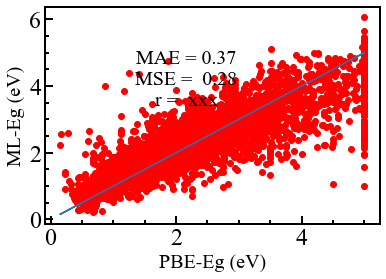

In [105]:
import matplotlib.pyplot as plot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pandas as pd
from sklearn import preprocessing
from pandas import DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from gplearn import genetic
from gplearn.genetic import SymbolicTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from scipy.stats import stats
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
import sklearn.ensemble as ensemble  # ensemble learning: 集成学习
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import matplotlib.pyplot as plt#计算准确率xgboost
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold


y_prediction=model.predict(X_test)
mse = mean_squared_error(y_test, y_prediction)
rmse = mse ** (1/2)
sse = np.sum((y_test - y_prediction) ** 2)
sst = np.sum((y_test - np.mean(X_test)) ** 2)
R2= 1 - sse / sst
# r = pearsonr(y_test, y_prediction)

from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(y_test, y_prediction)
print("R2:",R2)
print("RMSE:",rmse)

print("MAE:",MAE)


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
R2b = r2_score(y_test, y_prediction)
MSE = mean_squared_error(y_test, y_prediction)
print("R2b:",R2b)
print("MSE:",MSE)

#plot图
plt.yticks(fontproperties = 'Times New Roman', size = 14)
plt.xticks(fontproperties = 'Times New Roman', size = 14)
plt.rcParams['font.sans-serif'] = 'Roman'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(y_test, y_test, label='Real Data')
plt.scatter(y_test, y_prediction, label='Predict', c='r')
ax=plt.gca()
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2)

plt.tick_params(width=2)
ax.xaxis.set_tick_params(labelsize=24)
plt.tick_params(which='major',length=8)
plt.tick_params(which='minor',length=4,width=2)
ax.yaxis.set_tick_params(labelsize=24)
xminorLocator   = MultipleLocator(1000)
yminorLocator   = MultipleLocator(1000)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
plt.minorticks_on()

plt.xlabel("PBE-Eg (eV)", fontproperties = 'Times New Roman', size = 20)
plt.ylabel("ML-Eg (eV)", fontproperties = 'Times New Roman', size = 20)

plt.text(2.2, 2.8, 'MAE = %.2f \nMSE =  %.2f \nr =  xxx \n' % (MAE, MSE), fontproperties = 'Times New Roman', size = 20, horizontalalignment='center')
plt.savefig('xgboost-test.tif', dpi=300, bbox_inches = 'tight')
plt.show()